In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFile


from sklearn.metrics import confusion_matrix
import seaborn as sns


import os
from pathlib import Path

In [ ]:
device = 'cuda' if torch.cuda.is_available()  else 'cpu'
device

In [ ]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
!pwd

In [ ]:
!ls

In [ ]:

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/My Drive/FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET.zip'


extracted_folder_path = '/content/fire_smoke_dataset'

# Create directory if it doesn't exist
os.makedirs(extracted_folder_path, exist_ok=True)

# Extract the zip file
import zipfile
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdirectories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(extracted_folder_path)

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get the image path list
image_path_list = []
for root, dirs, files in os.walk(extracted_folder_path):
    for file in files:
        if file.endswith(".jpg"):
            image_path_list.append(os.path.join(root, file))


# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = os.path.basename(os.path.dirname(random_image_path))

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [ ]:
train_dir = '/content/drive/My Drive/fire_smoke_dataset/train'
test_dir = '/content/drive/My Drive/fire_smoke_dataset/test'


train_dir, test_dir

In [ ]:
transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), # Randomly crop the image to 224x224
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
    transforms.RandomRotation(15), # Randomly rotate the image by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Randomly change the brightness, contrast, saturation, and hue
    transforms.RandomVerticalFlip(p=0.1), # Randomly flip the image vertically with a probability of 0.1
    transforms.ToTensor(), # Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # A standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

In [ ]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root='/content/fire_smoke_dataset/train', # target folder of images
                                  transform=transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root='/content/fire_smoke_dataset/test',
                                 transform=transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

In [ ]:
class_names = train_data.classes
class_names

['Smoke', 'fire', 'non fire']

In [ ]:
image, label = next(iter(train_dataloader))
print(image.shape)
print(label)

torch.Size([32, 3, 224, 224])
tensor([2, 0, 0, 1, 1, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 2, 1, 2, 0, 0, 0,
        0, 0, 2, 0, 1, 0, 2, 2])


In [ ]:
mobilenet_V2 = models.mobilenet_v2(pretrained=True)
num_features = mobilenet_V2.classifier[1].in_features


for param in mobilenet_V2.parameters():
    param.requires_grad = False

num_classes = len(train_data.classes)
# Modify classifier to match number of classes
mobilenet_V2.classifier[1] = nn.Linear(num_features,num_classes )

for param in mobilenet_V2.classifier.parameters():
    param.requires_grad = True

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_V2.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_V2.parameters(), lr=0.001)

In [ ]:
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

In [ ]:
print(os.cpu_count())

In [ ]:
num_workers = os.cpu_count()
batch_size = 32
time_out = 60
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=batch_size, # how many samples per batch?
                              num_workers=num_workers,
                              persistent_workers=True,
                              timeout = time_out,# how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

In [ ]:
def train_model(model, train_dataloader, criterion, optimizer, device, num_epochs=50, epochs_per_iteration=10):
    model.train()
    total_loss = 0.0
    total_correct_predictions = 0
    total_predictions = 0

    for iteration in range(num_epochs // epochs_per_iteration):
        print(f"Iteration {iteration + 1}/{num_epochs // epochs_per_iteration}:")
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for epoch in range(epochs_per_iteration):
            for batch_idx, (data, target) in enumerate(train_dataloader):
                data, target = data.to(device), target.to(device)  # Transfer data to device

                optimizer.zero_grad()
                outputs = model(data)
                loss = criterion(outputs, target)
                loss.backward()
                optimizer.step()

                # Accumulate loss and calculate accuracy
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_predictions += target.size(0)
                correct_predictions += (predicted == target).sum().item()

            # Print epoch statistics
            epoch_loss = running_loss / len(train_dataloader)
            epoch_accuracy = correct_predictions / total_predictions * 100
            print(f"Epoch [{(iteration * epochs_per_iteration) + epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

        # Accumulate statistics for the iteration
        total_loss += running_loss
        total_correct_predictions += correct_predictions

    # Calculate overall statistics
    overall_loss = total_loss / (len(train_dataloader) * (num_epochs // epochs_per_iteration))
    overall_accuracy = total_correct_predictions / (total_predictions * (num_epochs // epochs_per_iteration)) * 100

    print(f'Finished Training\nOverall Loss: {overall_loss:.4f}, Overall Accuracy: {overall_accuracy:.2f}%')


In [ ]:
import time
t0 = time.time()
train_model(mobilenet_V2, train_dataloader, criterion, optimizer, device)
t_final = time.time()
print(f" Time taken {t_final - t0}")

In [ ]:
save_model(mobilenet_V2, '/content/drive/MyDrive/model_checkpoint.pth')


Model saved to /content/drive/MyDrive/model_checkpoint.pth


In [ ]:
def evaluation(model, test_dataloader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    test_preds = []  # List to store predictions
    test_labels = []  # List to store true labels

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            # Append predictions and true labels to the lists
            test_preds.extend(predicted.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_dataloader)
    accuracy = 100. * correct / len(test_dataloader.dataset)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return test_loss, accuracy, test_labels, test_preds


In [ ]:
test_loss, test_accuracy, test_labels, test_preds = evaluation(mobilenet_V2, test_dataloader, criterion, device)

Test Loss: 0.2367, Test Accuracy: 91.64%


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Normalize the confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

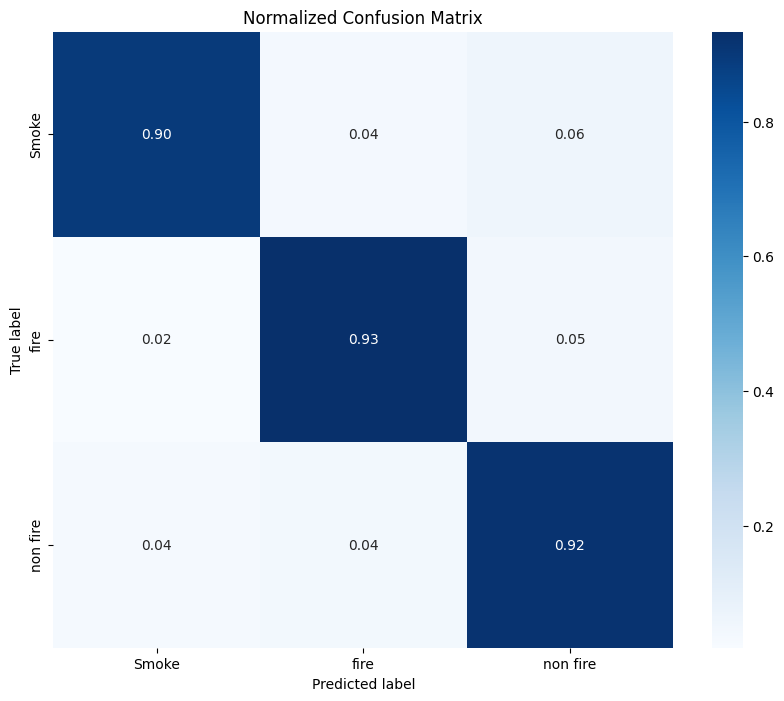

In [ ]:
# plot_confusion_matrix(labels, preds, class_names)
plot_confusion_matrix(test_labels, test_preds, class_names)